!["Logo"](https://github.com/Fortuz/rl_education/blob/main/assets/logo.png?raw=1)

Created by **Zoltán Barta**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/DQN/dqn.ipynb)


# Deep Q-Networks (DQN) and Its Variants

## Introduction

Reinforcement Learning (RL) has seen significant advancements with the introduction of Deep Q-Networks (DQN). Originally proposed by **Mnih et al. (2013)**, DQN combines deep learning with Q-learning to approximate optimal action-value functions in complex environments. This approach has been instrumental in enabling agents to play Atari games at superhuman levels.

While DQN has demonstrated impressive performance, it suffers from instability and overestimation issues. To address these challenges, several improved versions have been proposed:

- **Double DQN**: Mitigates overestimation bias in Q-learning by using a separate target network for action selection and evaluation.
- **Dueling DQN**: Introduces a novel architecture that separately estimates state-value and advantage functions to improve learning efficiency.

## Objectives

This notebook explores the implementation and evaluation of these DQN variants. Specifically, it aims to:

- Implement a baseline **DQN** agent.
- Extend it with **Double DQN** to reduce overestimation.
- Incorporate **Dueling DQN** for better action-value estimation.
- Evaluate enhancements like **PER**

The experiments will be conducted using **Gymnasium**'s CartPole-v1 environment, and the models will be implemented using **PyTorch**.

## References

- [DQN Paper (2013)](https://arxiv.org/abs/1312.5602)
- [Double DQN (2015)](https://arxiv.org/abs/1509.06461)
- [Dueling DQN (2015)](https://arxiv.org/abs/1511.06581)

## **Homework 3**
In this assignment, you will implement **Dueling DQN**, an improved version of the Deep Q-Network (DQN) that separates **state-value estimation** from **action advantage estimation**. Dueling DQN is particularly useful in environments where some actions are redundant in certain states.

Your task is to:
- Implement the **forward pass** of the dueling architecture.  
- Train and evaluate the agent on an **Atari** or **Gym environment**.  
- For details, check Cell #5

In [43]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Experience Replay

### Introduction

In reinforcement learning, an agent interacts with an environment by taking actions and receiving rewards. However, learning directly from consecutive experiences can lead to inefficiencies and instability. **Experience Replay** is a crucial technique introduced to improve sample efficiency and stability in **Deep Q-Networks (DQN)**.

Originally proposed by **Mnih et al. (2013)**, Experience Replay involves storing past transitions in a memory buffer and randomly sampling batches of experiences for training. This helps break the correlation between consecutive observations, leading to more stable learning.

### How It Works

The core idea behind Experience Replay is to maintain a **Replay Buffer** that stores transitions of the form:

$$ (s_t, a_t, r_t, s_{t+1}) $$

where:
- $s_t$ is the current state,
- $a_t$ is the action taken,
- $r_t$ is the reward received,
- $s_{t+1}$ is the next state.

At each training step:
1. The agent **samples** a mini-batch of transitions from the replay buffer.
2. It updates the Q-network using these past experiences rather than relying only on the latest transition.
3. This process **reduces correlation** between updates and leads to more efficient learning.

### Benefits of Experience Replay

- **Breaks Correlation:** Sampling from a replay buffer prevents the network from learning directly from consecutive states, reducing correlation in training updates.
- **Improves Sample Efficiency:** By reusing past experiences, the agent learns more efficiently compared to using only the most recent transitions.
- **Enables Off-Policy Learning:** Experience Replay allows learning from past experiences, making it possible to use older transitions even if the current policy has changed.
- **Stabilizes Training:** Helps smooth out learning by reducing variance in updates.


### Implementation in DQN

A **ReplayMemory** class is typically used to store and manage the experience replay buffer. The key methods include:

- **push()** – Stores a transition in the buffer.
- **sample()** – Retrieves a random mini-batch of experiences for training.
- **__len__()** – Returns the number of stored experiences.



In [44]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

The **epsilon-greedy action selection** strategy balances **exploration** and **exploitation** by choosing the action with the highest estimated Q-value with probability **$1 - \epsilon$** and selecting a random action with probability **$\epsilon$**, where **$\epsilon$** is often annealed over time to transition from exploration to exploitation. More on it in the [K-armed bandit notebook.](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/1.%20K-armed%20Bandit/k_armed_bandit_solution.ipynb)

In [45]:
class EpsilonGreedyActionSelection():

    def __init__(self, epsilon_start, epsilon_end, epsilon_decay,n_actions):
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.n_actions = n_actions

    def get_epsilon(self, step):
        return self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * step / self.epsilon_decay)

    def select_action(self, policy_net, state, step):
        sample = random.random()
        epsilon = self.get_epsilon(step)
        if sample > epsilon:
            with torch.no_grad():
                return policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)

## MLP Policy

### What is the MLP Policy?

The **MLP (Multi-Layer Perceptron) Policy** is a **feedforward neural network** used as the function approximator in Deep Q-Networks (DQN). It maps **observations (state representations)** to **Q-values for each action**, enabling the agent to make decisions based on learned value estimates.

### Why Are We Using It?

We use an **MLP-based policy** because:
- It can learn **non-linear representations** of the environment, making it suitable for complex state spaces.
- It is computationally efficient and can be trained using **gradient-based optimization**.
- It generalizes well across similar states, improving sample efficiency.

### When Is It Worth Using?

- **Tabular Q-learning becomes infeasible**: When the state space is large or continuous, using a neural network as a function approximator is necessary.
- **Environments with structured features**: The MLP policy can extract meaningful patterns from structured state representations.
- **Computational efficiency matters**: MLPs are simpler and faster to train compared to deeper or more complex architectures like CNNs or RNNs.

In our implementation, the **MLP consists of three fully connected layers** with **ReLU activation**, ensuring non-linearity and effective gradient flow.

## MLP Size for Atari Environments

For solving **Atari** environments with Deep Q-Networks (DQN), using a simple **Multi-Layer Perceptron (MLP) policy** is generally **not sufficient** due to the high-dimensional **pixel-based** state representation. Instead, **Convolutional Neural Networks (CNNs)** are commonly used for feature extraction.

However, if **low-dimensional features** (such as RAM states) are used instead of raw pixels, an **MLP policy** can still be effective. The required size depends on:

1. **State Space Dimensionality**:
   - If using raw pixels ($84 \times 84 \times 4$ stacked frames), a deep CNN is preferred.
   - If using **RAM states** (128-dimensional), an **MLP with 2–3 hidden layers of 256–512 neurons** is generally effective.

2. **Action Space Complexity**:
   - More complex environments with **many discrete actions** might require larger networks to capture nuanced decision-making.

3. **Computational Constraints**:
   - A larger network improves representation learning but increases training time.
   - Standard DQN implementations for **Atari** use **three convolutional layers followed by a fully connected MLP with 512 neurons**.


In [46]:
class MlpPolicy(nn.Module):

    def __init__(self, n_observations, n_actions,num_hidden=128):
        super(MlpPolicy, self).__init__()
        self.layer1 = nn.Linear(n_observations, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_hidden)
        self.layer3 = nn.Linear(num_hidden, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Dueling Policy

### What is the Dueling Architecture?

The **Dueling DQN** architecture is an improvement over standard Deep Q-Networks (DQN) that helps the agent **better differentiate** between valuable states and valuable actions. Introduced by **Wang et al. (2015)**, the **dueling network architecture** modifies the Q-value function by separately estimating:

1. **State Value Function**: $V(s)$ measures how valuable a given state is, regardless of the action taken.
2. **Advantage Function**: $A(s, a)$ captures the relative importance of each action within a given state.

Instead of directly computing Q-values, the network learns:

$$
Q(s, a) = V(s) + A(s, a) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a')
$$

where the subtraction ensures that the **advantage function is centered**, preventing redundant representations.

### Why Use a Dueling Architecture?

- **Better State Evaluation**: The network can learn to **evaluate states independently of actions**, which is useful when some actions have little impact.
- **More Efficient Learning**: Helps **generalize learning** across actions, leading to faster convergence.
- **Improved Stability**: Reduces unnecessary action-value variations in states where action choice doesn’t matter.

### When Is It Useful?

- **Large or Discrete Action Spaces**: The dueling structure helps **identify important states** without needing to compare all actions explicitly.
- **Environments with Redundant Actions**: When **some actions have no effect** in certain states, the architecture ensures learning is focused on meaningful actions.
- **Atari & Complex RL Tasks**: Many **Atari games** benefit from this architecture due to the complexity of state-action relationships.


## **Homework**

- **Create a shared feature extraction layer** for state representations.
- **Defining two separate branches:**
  1. **State-Value Stream** $V(s)$ – Computes how good a state is, independent of actions.
  2. **Advantage Stream** $A(s, a)$ – Computes how much better or worse each action is relative to the state value.
- **Merging these two streams using the dueling Q-value formula:**

$$
Q(s, a) = V(s) + \left(A(s, a) - \frac{1}{|A|} \sum_{a{\prime}} A(s, a{\prime})\right)
$$

![Dueling Architecture](https://github.com/Fortuz/rl_education/blob/main/DQN/Dueling_NN.png?raw=1)

In [ ]:
class DuelingMlpPolicy(nn.Module):
    """
    Dueling Network architecture for DQN.
    """
    def __init__(self, n_observations, n_actions, num_hidden=256):
        super(DuelingMlpPolicy, self).__init__()
        ###############CODE HERE################

        self.fc_1 = nn.Linear(n_observations, num_hidden)
        self.ln1 = nn.LayerNorm(num_hidden)
        self.fc_2 = nn.Linear(num_hidden, num_hidden)
        self.ln2 = nn.LayerNorm(num_hidden)
        self.fc_3 = nn.Linear(num_hidden, num_hidden)
        self.ln3 = nn.LayerNorm(num_hidden)
        self.fc_5 = nn.Linear(num_hidden, num_hidden)
        self.ln5 = nn.LayerNorm(num_hidden)
        self.fc_6 = nn.Linear(num_hidden, num_hidden)
        self.ln6 = nn.LayerNorm(num_hidden)      
        self.fc_value = nn.Linear(num_hidden, 1)
        self.fc_action = nn.Linear(num_hidden, n_actions)

        ########################################

    def forward(self, x):
        ###############CODE HERE################

        x = F.relu(self.ln1(self.fc_1(x)))
        x = F.relu(self.ln2(self.fc_2(x)))
        x = F.relu(self.ln3(self.fc_3(x)))
        value = F.relu(self.ln5(self.fc_5(x)))
        action = F.relu(self.ln6(self.fc_6(x)))
        value = self.fc_value(value)
        action = self.fc_action(action)
        q_values = value + (action - action.mean(dim=1, keepdim=True))

        ########################################
        return q_values

## DQN Agent

### What is the DQNAgent?

The **DQNAgent** is the core component responsible for training and decision-making in a **Deep Q-Network (DQN)** setup. It integrates key reinforcement learning concepts, including **experience replay, target networks, and action selection**, to improve the stability and efficiency of learning.

### Key Features

1. **Experience Replay**:
   - Stores transitions in a **Replay Buffer** to break correlation between consecutive experiences.
   - Uses **mini-batch sampling** for training to improve data efficiency.

2. **Policy and Target Networks**:
   - Maintains two networks:
     - **Policy Network**: The main neural network used for action selection.
     - **Target Network**: A delayed copy of the policy network, used for stabilizing training.
   - The **target network is updated periodically** using a soft update mechanism controlled by **$\tau$**.

3. **Epsilon-Greedy Action Selection**:
   - Uses an **action selection strategy** to balance exploration vs. exploitation.

4. **Optimization Process**:
   - Trains the network using **Smooth L1 Loss (Huber loss)** to handle noisy rewards.
   - Uses the **Adam optimizer** for gradient-based learning.
   - **Gradient clipping** prevents instability in training.

5. **Target Network Hard Update**:
   - Copy the parameters of policy net to the target network.

In [48]:
import copy


class DQNAgent:

    def __init__(self, n_observations, n_actions, action_selection,policy_net,memory_capacity=10000,
                 optimization_iterations = 15 ,
                 batch_size=128,
                 target_update_interval=10,
                 gamma=0.999,
                 learning_rate=0.001):
        self.n_observations = n_observations
        self.n_actions = n_actions
        self.memory = ReplayMemory(memory_capacity)
        self.batch_size = batch_size
        self.gamma = gamma
        self.optimization_iterations = optimization_iterations
        self.target_net_update_interval = target_update_interval

        self.policy_net = policy_net.to(device)
        self.target_net = copy.deepcopy(self.policy_net)  # Exact copy of the object
        self.target_net.to(device)
        self.target_net.eval()
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(self.policy_net.parameters(),
                                    lr=learning_rate)

        self.steps_done = 0

        self.action_selection = action_selection

    def __call__(self, state):
        self.steps_done += 1
        return self.action_selection.select_action(self.policy_net, state, self.steps_done)

    def push(self, *args):
        self.memory.push(*args)

    def optimize_model(self):

        if len(self.memory) < self.batch_size:
            return
        for i in range(self.optimization_iterations):
            transitions = self.memory.sample(self.batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor(
                tuple(map(lambda s: s is not None, batch.next_state)),
                device=device,
                dtype=torch.bool
            )
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            state_action_values = self.policy_net(state_batch).gather(1, action_batch)

            next_state_values = torch.zeros(self.batch_size, device=device)
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

            expected_state_action_values = reward_batch + self.gamma * next_state_values

            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

            self.optimizer.zero_grad()
            loss.backward()
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

    def update_target_net(self,step):
        if step % self.target_net_update_interval == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

## Double DQN Agent

### What is Double DQN?

The **Double DQN (DDQN)** agent is an enhancement over standard **Deep Q-Networks (DQN)** that mitigates **overestimation bias** in Q-learning. Introduced by **van Hasselt et al. (2015)**, **Double Q-learning** improves the stability of learning by decoupling the **action selection** and **action evaluation** steps.

### Key Difference from DQN

In **DQN**, the target Q-values are computed as:

$$
Q_{\text{target}}(s, a) = r + \gamma \max_{a'} Q_{\text{target}}(s', a')
$$

This approach often **overestimates Q-values**, leading to instability.

**Double DQN fixes this by using two networks differently:**
1. **The policy network selects the next action**:
   $$
   a^* = \arg\max_{a'} Q_{\text{policy}}(s', a')
   $$
2. **The target network evaluates the chosen action**:
   $$
   Q_{\text{target}}(s, a) = r + \gamma Q_{\text{target}}(s', a^*)
   $$

This reduces overestimation because the **same network is not used for both selection and evaluation**.

In [49]:
class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent:
    - Overrides the optimize_model() to do the Double Q-learning target.
    """
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        for _ in range(self.optimization_iterations):
            transitions = self.memory.sample(self.batch_size)
            batch = Transition(*zip(*transitions))

            non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Current Q estimates
            q_values = self.policy_net(state_batch).gather(1, action_batch)

            next_state_values = torch.zeros(self.batch_size, device=device)

            # 1) Choose best action in next_state via policy_net
            if non_final_mask.any():
                next_actions = self.policy_net(non_final_next_states).argmax(1).unsqueeze(1)

                # 2) Evaluate that action using target_net
                next_q = self.target_net(non_final_next_states).gather(1, next_actions).squeeze(1)

                next_state_values[non_final_mask] = next_q.detach()

            # Compute the target
            expected_q_values = reward_batch + (self.gamma * next_state_values)

            # Loss and update
            loss = F.smooth_l1_loss(q_values, expected_q_values.unsqueeze(1))

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(self.policy_net.parameters(), 1.0)
            self.optimizer.step()

In [50]:
def plot_returns(episode_returns, show_result=False,ma = 25):
    """
    Plots the total return (sum of rewards per episode) for an Atari Pong agent.

    Args:
        episode_returns (list): A list of total rewards per episode.
        show_result (bool): Whether to show the final result or continue updating during training.
    """
    plt.figure(1)
    returns_t = torch.tensor(episode_returns, dtype=torch.float)

    if show_result:
        plt.title('Final Training Results')
    else:
        plt.clf()
        plt.title('Training Progress - Pong Agent')

    plt.xlabel('Episode')
    plt.ylabel('Total Return')
    plt.plot(returns_t.numpy(), label="Episode Returns")

    if len(returns_t) >= ma:
        means = returns_t.unfold(0, ma, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(ma-1), means))
        plt.plot(means.numpy(), linestyle='dashed', label=f"{ma}-Episode Moving Avg")

    plt.legend()
    plt.pause(0.001)  # Pause a bit to update the plot

    # Display in Jupyter Notebook properly
    if 'is_ipython' in globals() and is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Training Script for the DQN Agent

### Overview

The following script is responsible for training a **DQN-based agent** in a reinforcement learning environment. It follows the **standard reinforcement learning loop**, where the agent interacts with the environment, collects experience, and updates its policy over multiple episodes.

### Training Process

1. **Initialize Training Parameters**:
   - The number of **training episodes** is set based on the availability of a **GPU (CUDA/MPS)**.
   - Stores **returns (total rewards per episode)** and **episode lengths** for performance tracking.

2. **Episode Loop**:
   - The environment is **reset** at the start of each episode.
   - The initial **state is converted to a tensor** for processing by the neural network.

3. **Agent-Environment Interaction**:
   - The agent **selects an action** based on the current state.
   - The action is **executed in the environment**, producing:
     - **New observation** (next state).
     - **Reward** received for the action.
     - **Termination signal** (whether the episode has ended).
   - The transition **(state, action, next_state, reward)** is stored in the agent's **Replay Buffer**.

4. **Optimization Step**:
   - The agent **samples experiences from the buffer** and **updates the policy network**.
   - **Target network updates** ensure stable learning.

In [64]:
BATCH_SIZE = 512
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2500
LR = 1e-5
SAVE_PATH = "dqn_pong.pth"
SAVE_INTERVAL = 10
MEMORY_CAPACITY = 100_000
OPTIMIZATION_ITERATIONS = 5
TARGET_UPDATE_INTERVAL = 10
EPISODES = 50


In [65]:
env = gym.make("ALE/Pong-ram-v5",)
n_observation = env.observation_space.shape[0]
n_actions = env.action_space.n

In [66]:
policy = DuelingMlpPolicy(n_observation, n_actions, num_hidden=256)

# Load a pretrained model if needed by uncommenting the line below
# policy.load_state_dict(torch.load(SAVE_PATH))
policy.to(device)
action_selection = EpsilonGreedyActionSelection(EPS_START, EPS_END, EPS_DECAY,n_actions)
agent = DoubleDQNAgent(n_observation, n_actions, action_selection, policy, memory_capacity=MEMORY_CAPACITY,
                 optimization_iterations=OPTIMIZATION_ITERATIONS, batch_size=BATCH_SIZE,
                 target_update_interval=TARGET_UPDATE_INTERVAL, gamma=GAMMA,learning_rate=LR)


Episodes: 100%|██████████| 50/50 [17:12<00:00, 20.65s/it]

Training complete


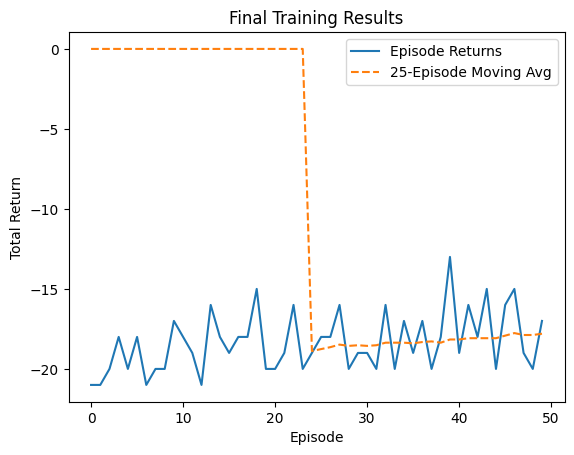

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [67]:
import torch
import matplotlib.pyplot as plt
from itertools import count
from tqdm import tqdm

training_data = {
    'returns': [],
    'episode_lengths': []
}
total_steps = 0

for i_episode in tqdm(range(EPISODES), total=EPISODES, desc='Episodes'):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).div_(255.0).unsqueeze(0)  # Normalize before passing
    episode_return = 0

    for t in count():
        action = agent(state)


        next_observation, reward, terminated, truncated, _ = env.step(action.item())

        # Normalize observation & convert to tensor
        # We apply normalization here to avoid unstable gradients
        # The state representation is 128 integer vector, ranging from 0 to 255
        # We normalize it to 0-1 range by dividing by 255
        next_state = torch.tensor(next_observation, dtype=torch.float32, device=device).div_(255.0).unsqueeze(0) if not terminated else None
        reward = torch.tensor([reward], device=device)


        episode_return += reward.item()
        agent.push(state, action, next_state, reward)
        state = next_state
        agent.optimize_model()
        agent.update_target_net(total_steps)

        total_steps += 1

        if terminated or truncated:
            training_data['returns'].append(episode_return)
            training_data['episode_lengths'].append(t + 1)
            plot_returns(training_data['returns'])
            break

    # Save model checkpoint periodically
    if i_episode % SAVE_INTERVAL == 0:
        torch.save(policy.state_dict(), SAVE_PATH)

print('Training complete')
plot_returns(training_data['returns'], show_result=True)
plt.ioff()

In [68]:
import time

env = gym.make("ALE/Pong-ram-v5",render_mode='human')
NUM_EPISODES = 3
RENDER_DELAY = 0.01
for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).div_(255.0).unsqueeze(0)  # Normalize

    total_reward = 0
    done = False

    while not done:
        env.render()
        time.sleep(RENDER_DELAY)

        with torch.no_grad():
            action = agent.policy_net(state).argmax(dim=1).item()

        next_state, reward, terminated, truncated, _ = env.step(action)

        state = torch.tensor(next_state, dtype=torch.float32, device=device).div_(255.0).unsqueeze(0)

        total_reward += reward
        done = terminated or truncated

    print(f"Episode {episode + 1}/{NUM_EPISODES} - Total Reward: {total_reward}")

env.close()

Episode 1/3 - Total Reward: -19.0
Episode 2/3 - Total Reward: -17.0
Episode 3/3 - Total Reward: -19.0
